# Clasificación de Imágenes con PyTorch y Caltech101
Este notebook entrena un modelo CNN en PyTorch usando un subconjunto del dataset Caltech101, evalúa su rendimiento, y permite cargar imágenes desde Google Drive para predecir su clase.

In [1]:
# Paso 1: Montar Google Drive para acceder al dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

origen = '/content/drive/MyDrive/101_ObjectCategories'
clases_disponibles = [d for d in os.listdir(origen) if os.path.isdir(os.path.join(origen, d))]
print("Clases disponibles:")
print(clases_disponibles)

Clases disponibles:
['trilobite', 'wrench', 'tick', 'watch', 'water_lilly', 'windsor_chair', 'yin_yang', 'wheelchair', 'wild_cat', 'umbrella', 'strawberry', 'soccer_ball', 'sea_horse', 'snoopy', 'stapler', 'stegosaurus', 'stop_sign', 'sunflower', 'starfish', 'scorpion', 'rooster', 'saxophone', 'pyramid', 'pizza', 'scissors', 'schooner', 'rhino', 'platypus', 'revolver', 'pigeon', 'okapi', 'octopus', 'nautilus', 'menorah', 'metronome', 'panda', 'minaret', 'Motorbikes', 'pagoda', 'mayfly', 'lamp', 'lobster', 'Leopards', 'laptop', 'llama', 'kangaroo', 'ketch', 'mandolin', 'joshua_tree', 'lotus', 'grand_piano', 'hawksbill', 'gramophone', 'gerenuk', 'garfield', 'helicopter', 'headphone', 'ibis', 'inline_skate', 'hedgehog', 'euphonium', 'Faces', 'Faces_easy', 'flamingo', 'ewer', 'electric_guitar', 'emu', 'ferry', 'elephant', 'flamingo_head', 'crocodile', 'crocodile_head', 'dragonfly', 'crab', 'dalmatian', 'cup', 'dolphin', 'crayfish', 'dollar_bill', 'dataset', 'ceiling_fan', 'butterfly', 'cam

In [3]:
import shutil
import os

# Ruta donde se crea el dataset
drive_base_path = '/content/drive/MyDrive/101_ObjectCategories'
dataset_dir = os.path.join(drive_base_path, 'dataset')

# Eliminar la carpeta 'dataset' completa si ya existe
if os.path.exists(dataset_dir):
    print(f"🧹 Eliminando dataset anterior en: {dataset_dir}")
    shutil.rmtree(dataset_dir)
else:
    print("✅ No hay dataset previo, limpio para comenzar.")

# Crear nuevamente las carpetas vacías
os.makedirs(os.path.join(dataset_dir, "train"), exist_ok=True)
os.makedirs(os.path.join(dataset_dir, "test"), exist_ok=True)

print("📁 Dataset limpio y preparado en:")
print(f"  - Train: {os.path.join(dataset_dir, 'train')}")
print(f"  - Test:  {os.path.join(dataset_dir, 'test')}")


🧹 Eliminando dataset anterior en: /content/drive/MyDrive/101_ObjectCategories/dataset
📁 Dataset limpio y preparado en:
  - Train: /content/drive/MyDrive/101_ObjectCategories/dataset/train
  - Test:  /content/drive/MyDrive/101_ObjectCategories/dataset/test


In [4]:
# Paso 2: Preparar rutas y dataset con validaciones y partición dinámica
import os
from glob import glob
import shutil

# Esta es la carpeta donde están las clases directamente
drive_base_path = '/content/drive/MyDrive/101_ObjectCategories'
os.makedirs(drive_base_path, exist_ok=True)

# Aquí se guardará el dataset procesado (train/test)
dataset_dir = os.path.join(drive_base_path, 'dataset')

def preparar_dataset(origen, destino_base, clases, max_img=100, test_ratio=0.2):
    train_path = os.path.join(destino_base, "train")
    test_path = os.path.join(destino_base, "test")
    for path in [train_path, test_path]:
        os.makedirs(path, exist_ok=True)

    for cls in clases:
        carpeta_origen = os.path.join(origen, cls)
        if not os.path.exists(carpeta_origen):
            print(f"⚠️ Carpeta no encontrada: {carpeta_origen}")
            continue

        imagenes = sorted(glob(os.path.join(carpeta_origen, "*.jpg")))
        total_disponibles = len(imagenes)

        if total_disponibles == 0:
            print(f"⚠️ No se encontraron imágenes para la clase '{cls}'")
            continue

        # Seleccionar hasta max_img, o todas si hay menos
        imagenes = imagenes[:max_img]
        n_total = len(imagenes)
        n_test = max(1, int(n_total * test_ratio))  # al menos 1 imagen para test
        n_train = n_total - n_test

        os.makedirs(os.path.join(train_path, cls), exist_ok=True)
        os.makedirs(os.path.join(test_path, cls), exist_ok=True)

        for i, img in enumerate(imagenes):
            destino = test_path if i >= n_train else train_path
            shutil.copy(img, os.path.join(destino, cls, os.path.basename(img)))

        print(f"✅ Clase '{cls}': {n_train} train / {n_test} test (de {n_total} imágenes disponibles)")

    return train_path, test_path

# Clases que queremos usar (verifica que existan antes)
clases = ["camera", "brain", "Faces", "watch", "ketch", "dollar_bill"]

# Corrección de la ruta de origen
base_origen = drive_base_path
train_dir, test_dir = preparar_dataset(base_origen, dataset_dir, clases)


✅ Clase 'camera': 40 train / 10 test (de 50 imágenes disponibles)
✅ Clase 'brain': 79 train / 19 test (de 98 imágenes disponibles)
✅ Clase 'Faces': 80 train / 20 test (de 100 imágenes disponibles)
✅ Clase 'watch': 80 train / 20 test (de 100 imágenes disponibles)
✅ Clase 'ketch': 80 train / 20 test (de 100 imágenes disponibles)
✅ Clase 'dollar_bill': 42 train / 10 test (de 52 imágenes disponibles)


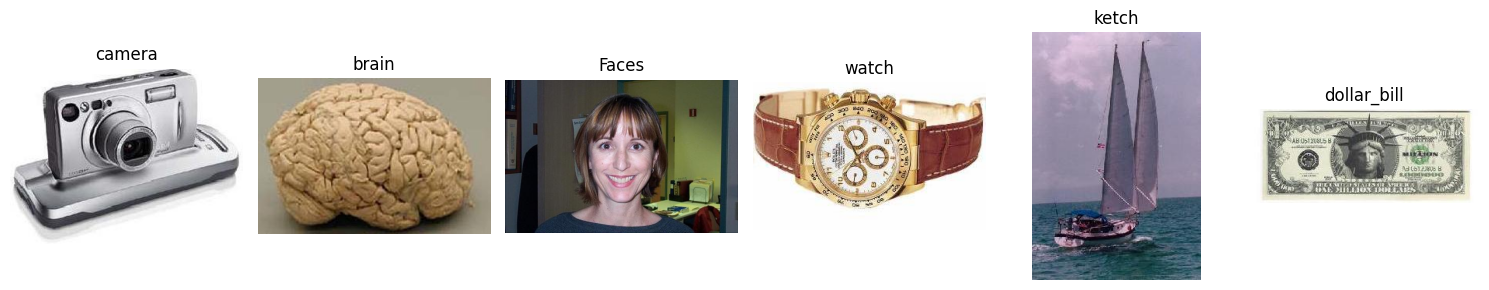

In [5]:
# Paso 3: Visualización de imágenes por clase


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob
import os

def mostrar_imagenes_test(test_path, clases):
    fig, axs = plt.subplots(1, len(clases), figsize=(15, 3))
    for i, cls in enumerate(clases):
        ruta_imagenes = glob(os.path.join(test_path, cls, "*.jpg"))
        if ruta_imagenes:
            img = mpimg.imread(ruta_imagenes[0])
            axs[i].imshow(img)
            axs[i].set_title(cls)
            axs[i].axis("off")
        else:
            axs[i].text(0.5, 0.5, f"No image\nfor {cls}", ha='center', va='center')
            axs[i].set_title(cls)
            axs[i].axis("off")
    plt.tight_layout()
    plt.show()


mostrar_imagenes_test(test_dir, clases)

In [6]:
# Paso 4: Transformación con data augmentation + entrenamiento con más épocas
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os

# Eliminamos carpetas vacías si quedaron clases sin imágenes
def eliminar_carpetas_vacias(ruta_base):
    for root, dirs, files in os.walk(ruta_base):
        for d in dirs:
            carpeta = os.path.join(root, d)
            if len(os.listdir(carpeta)) == 0:
                print(f"🗑️ Eliminando carpeta vacía: {carpeta}")
                os.rmdir(carpeta)

eliminar_carpetas_vacias(train_dir)
eliminar_carpetas_vacias(test_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🔁 Transformaciones mejoradas con data augmentation
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
]))

clases = train_dataset.classes
print(f"📂 Clases detectadas: {clases}")

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, len(clases))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 🔁 Entrenamiento con 20 épocas
for epoch in range(20):
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    #print(f"📈 Epoch {epoch+1} - Loss: {total_loss / len(train_loader):.4f}")
    # Pérdida (loss) promedio por época
    avg_loss = total_loss / len(train_loader)
    print(f"📈 Época {epoch+1}/{20} — Loss promedio: {avg_loss:.4f}")


📂 Clases detectadas: ['Faces', 'brain', 'camera', 'dollar_bill', 'ketch', 'watch']


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 137MB/s]


📈 Época 1/20 — Loss promedio: 0.9559
📈 Época 2/20 — Loss promedio: 0.5307
📈 Época 3/20 — Loss promedio: 0.3431
📈 Época 4/20 — Loss promedio: 0.3552
📈 Época 5/20 — Loss promedio: 0.3415
📈 Época 6/20 — Loss promedio: 0.2597
📈 Época 7/20 — Loss promedio: 0.2275
📈 Época 8/20 — Loss promedio: 0.1930
📈 Época 9/20 — Loss promedio: 0.2098
📈 Época 10/20 — Loss promedio: 0.2526
📈 Época 11/20 — Loss promedio: 0.1391
📈 Época 12/20 — Loss promedio: 0.1091
📈 Época 13/20 — Loss promedio: 0.1838
📈 Época 14/20 — Loss promedio: 0.1866
📈 Época 15/20 — Loss promedio: 0.2036
📈 Época 16/20 — Loss promedio: 0.1776
📈 Época 17/20 — Loss promedio: 0.1788
📈 Época 18/20 — Loss promedio: 0.2906
📈 Época 19/20 — Loss promedio: 0.1581
📈 Época 20/20 — Loss promedio: 0.1478


              precision    recall  f1-score   support

       Faces       1.00      1.00      1.00        20
       brain       0.95      1.00      0.97        19
      camera       1.00      1.00      1.00        10
 dollar_bill       0.91      1.00      0.95        10
       ketch       1.00      0.90      0.95        20
       watch       1.00      1.00      1.00        20

    accuracy                           0.98        99
   macro avg       0.98      0.98      0.98        99
weighted avg       0.98      0.98      0.98        99



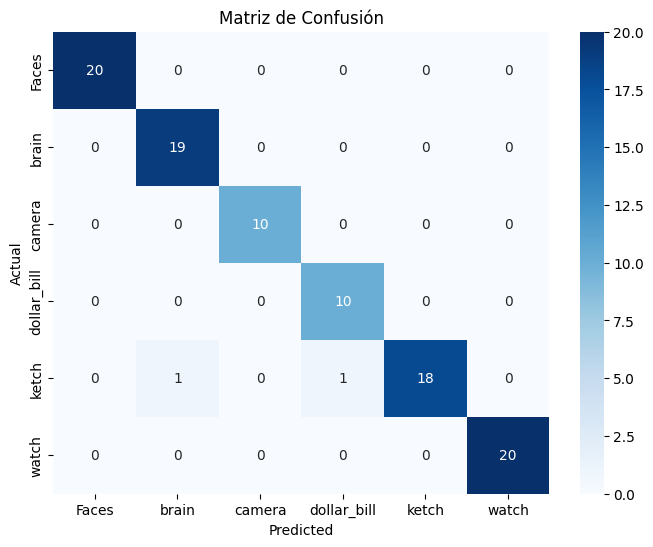

In [8]:
# Paso 5: Evaluación del modelo
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=clases))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=clases, yticklabels=clases, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Matriz de Confusión")
plt.show()

Saving ketch 1.jpg to ketch 1.jpg
📁 Imagen copiada a Drive: /content/drive/MyDrive/ketch 1.jpg

🔍 Clasificada como: **ketch**
📊 Probabilidad: 99.82%

🎯 Top 3 predicciones:
 - ketch: 99.82%
 - watch: 0.15%
 - dollar_bill: 0.02%


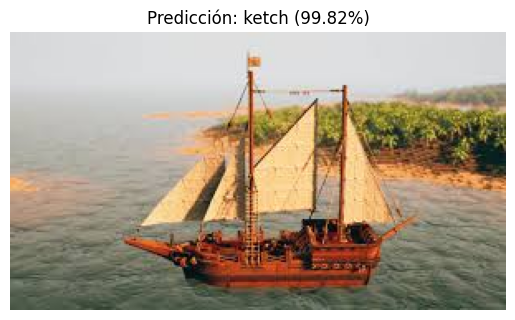

In [19]:
# Paso 6: Subir imagen, guardar en Drive, predecir y visualizar
from google.colab import files
from PIL import Image
import shutil
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os

# Subida
uploaded = files.upload()
file_name = next(iter(uploaded))

# Copiar con mismo nombre
ruta_destino = os.path.join("/content/drive/MyDrive", file_name)
shutil.copy(file_name, ruta_destino)
print(f"📁 Imagen copiada a Drive: {ruta_destino}")

# Leer imagen y transformar
img = Image.open(ruta_destino).convert('RGB')
img_tensor = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])(img).unsqueeze(0).to(device)

# Evaluar
model.eval()
with torch.no_grad():
    output = model(img_tensor)
    probabilities = F.softmax(output, dim=1)

    pred_idx = probabilities.argmax(dim=1).item()
    prob_pred = probabilities[0, pred_idx].item()

    print(f"\n🔍 Clasificada como: **{clases[pred_idx]}**")
    print(f"📊 Probabilidad: {prob_pred*100:.2f}%")
    print("\n🎯 Top 3 predicciones:")
    top3_probs, top3_idxs = torch.topk(probabilities, 3)
    for i in range(3):
        clase = clases[top3_idxs[0][i]]
        prob = top3_probs[0][i].item()
        print(f" - {clase}: {prob*100:.2f}%")

# Mostrar imagen
plt.imshow(img)
plt.title(f"Predicción: {clases[pred_idx]} ({prob_pred*100:.2f}%)")
plt.axis("off")
plt.show()


🔍 Clasificada como: **brain** 
📊 Probabilidad: 99.87%


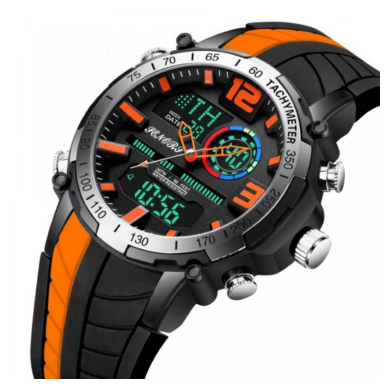

🎯 Top 3 predicciones:
 - brain: 99.87%
 - camera: 0.09%
 - watch: 0.04%

————————————————————————————————————————

🔍 Clasificada como: **ketch** 
📊 Probabilidad: 80.33%


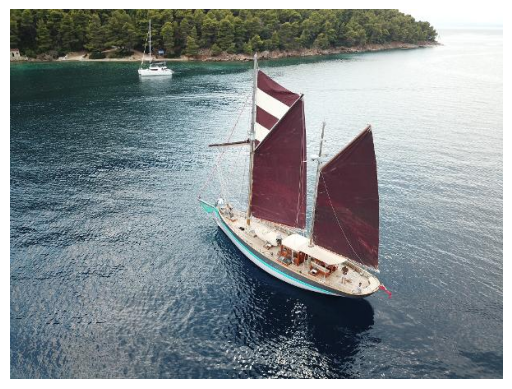

🎯 Top 3 predicciones:
 - ketch: 80.33%
 - watch: 12.21%
 - dollar_bill: 3.24%

————————————————————————————————————————

🔍 Clasificada como: **watch** 
📊 Probabilidad: 70.34%


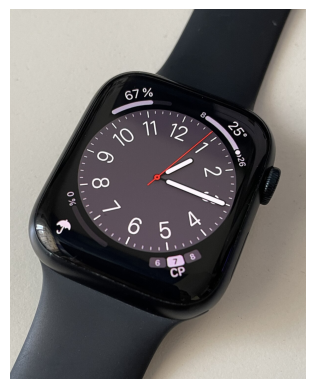

🎯 Top 3 predicciones:
 - watch: 70.34%
 - brain: 29.06%
 - camera: 0.55%

————————————————————————————————————————

🔍 Clasificada como: **dollar_bill** 
📊 Probabilidad: 99.97%


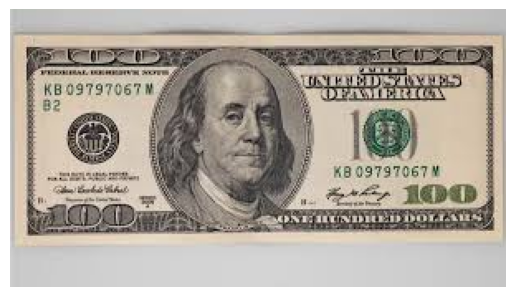

🎯 Top 3 predicciones:
 - dollar_bill: 99.97%
 - brain: 0.02%
 - camera: 0.01%

————————————————————————————————————————

🔍 Clasificada como: **Faces** 
📊 Probabilidad: 99.73%


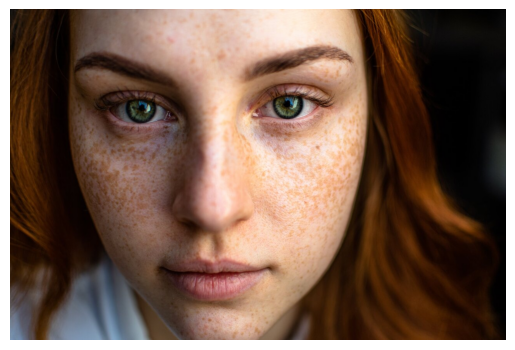

🎯 Top 3 predicciones:
 - Faces: 99.73%
 - brain: 0.24%
 - ketch: 0.01%

————————————————————————————————————————

🔍 Clasificada como: **Faces** 
📊 Probabilidad: 98.32%


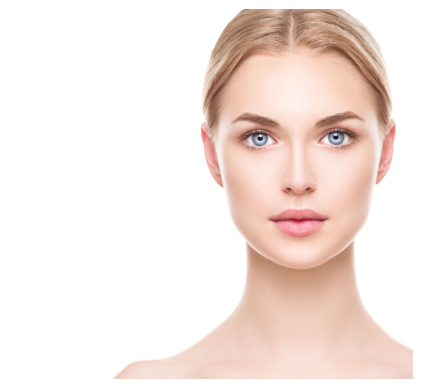

🎯 Top 3 predicciones:
 - Faces: 98.32%
 - brain: 0.88%
 - ketch: 0.35%

————————————————————————————————————————

🔍 Clasificada como: **brain** 
📊 Probabilidad: 96.04%


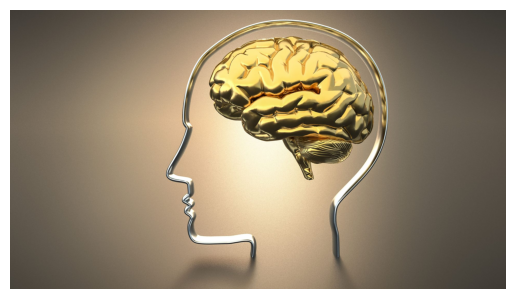

🎯 Top 3 predicciones:
 - brain: 96.04%
 - Faces: 2.70%
 - watch: 0.58%

————————————————————————————————————————

🔍 Clasificada como: **watch** 
📊 Probabilidad: 81.02%


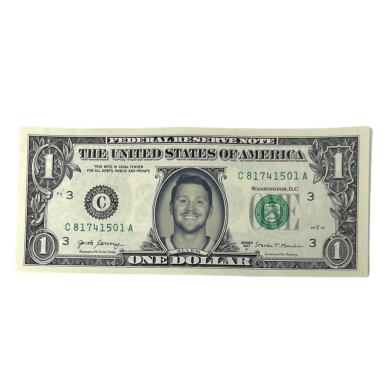

🎯 Top 3 predicciones:
 - watch: 81.02%
 - camera: 11.29%
 - dollar_bill: 6.47%

————————————————————————————————————————

🔍 Clasificada como: **brain** 
📊 Probabilidad: 100.00%


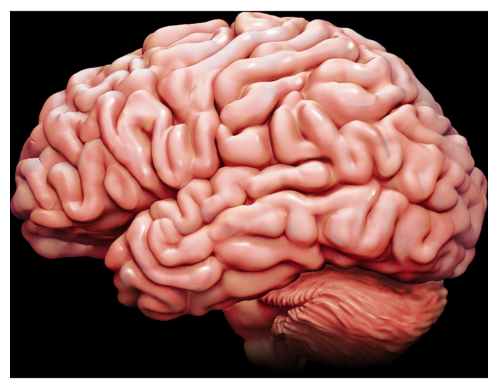

🎯 Top 3 predicciones:
 - brain: 100.00%
 - dollar_bill: 0.00%
 - camera: 0.00%

————————————————————————————————————————

🔍 Clasificada como: **Faces** 
📊 Probabilidad: 47.67%


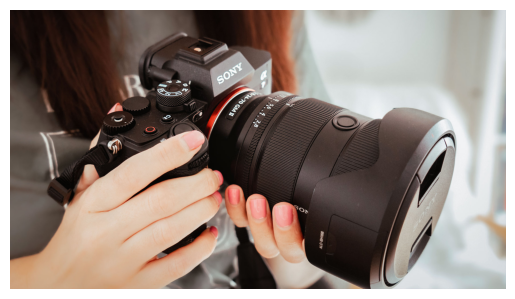

🎯 Top 3 predicciones:
 - Faces: 47.67%
 - camera: 19.45%
 - brain: 13.00%

————————————————————————————————————————

🔍 Clasificada como: **ketch** 
📊 Probabilidad: 99.82%


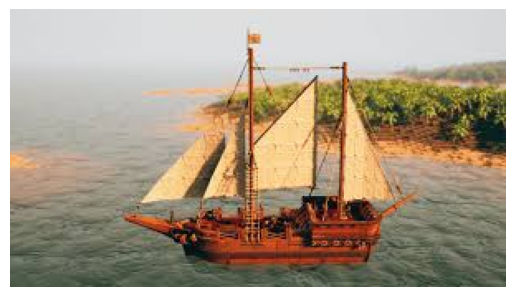

🎯 Top 3 predicciones:
 - ketch: 99.82%
 - watch: 0.15%
 - dollar_bill: 0.02%

————————————————————————————————————————

🔍 Clasificada como: **camera** 
📊 Probabilidad: 99.98%


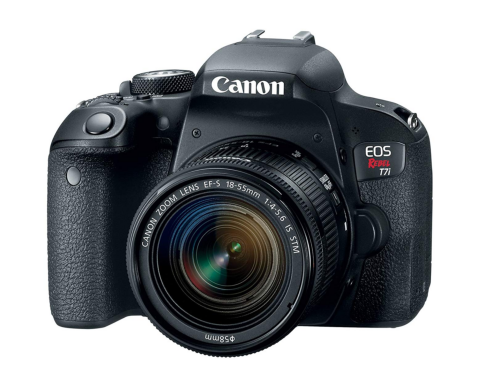

🎯 Top 3 predicciones:
 - camera: 99.98%
 - watch: 0.02%
 - brain: 0.00%

————————————————————————————————————————



,imagen,clase_predicha,probabilidad_%,top_2,prob_top_2_%,top_3,prob_top_3_%
0,watch 2.jpg,brain,99.87,camera,0.09,watch,0.04
1,ketch 2.jpg,ketch,80.33,watch,12.21,dollar_bill,3.24
2,watch 1.jpg,watch,70.34,brain,29.06,camera,0.55
3,dollar 1.jpg,dollar_bill,99.97,brain,0.02,camera,0.01
4,faces 2.jpg,Faces,99.73,brain,0.24,ketch,0.01
5,faces 1.jpg,Faces,98.32,brain,0.88,ketch,0.35
6,brain1.jpg,brain,96.04,Faces,2.70,watch,0.58
7,dollar 2.jpg,watch,81.02,camera,11.29,dollar_bill,6.47
8,brain 2.png,brain,100.00,dollar_bill,0.00,camera,0.00
9,camera 1.jpg,Faces,47.67,camera,19.45,brain,13.00


In [23]:
# 🔁 Paso 6 mejorado: evaluar en lote y mostrar cada imagen con detalles

from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import pandas as pd

eval_dir = '/content/drive/MyDrive/eval_images'  # carpeta con todas las imágenes
imagenes = [f for f in os.listdir(eval_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))]

# Lista para los resultados
resultados = []

for img_file in imagenes:
    img_path = os.path.join(eval_dir, img_file)
    img = Image.open(img_path).convert('RGB')
    img_t = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(img_t)
        probs = F.softmax(outputs, dim=1)
        top3_probs, top3_idxs = torch.topk(probs, 3)

    pred_idx = top3_idxs[0][0].item()
    pred_clase = clases[pred_idx]
    pred_prob = top3_probs[0][0].item()

    # Guardar resultados para la tabla
    resultados.append({
        'imagen': img_file,
        'clase_predicha': pred_clase,
        'probabilidad_%': round(pred_prob*100, 2),
        'top_2': clases[top3_idxs[0][1].item()],
        'prob_top_2_%': round(top3_probs[0][1].item()*100, 2),
        'top_3': clases[top3_idxs[0][2].item()],
        'prob_top_3_%': round(top3_probs[0][2].item()*100, 2),
    })

    # Mostrar imagen y predicción
    plt.imshow(img)
    plt.axis('off')
    print(f"🔍 Clasificada como: **{pred_clase}** \n📊 Probabilidad: {pred_prob*100:.2f}%")
    plt.show()

    # Mostrar top 3
    print("🎯 Top 3 predicciones:")
    for i in range(3):
        clase_i = clases[top3_idxs[0][i].item()]
        prob_i = top3_probs[0][i].item()
        print(f" - {clase_i}: {prob_i*100:.2f}%")
    print("\n" + "—" * 40 + "\n")

# Mostrar tabla resumen al final
tabla_resultados = pd.DataFrame(resultados)
display(tabla_resultados)
